In [1]:
import torchvision
import torchvision.transforms as transforms
import torch
from torch import nn
import numpy as np
import math
import matplotlib.pyplot as plt
import IPython.display as display
from IPython.display import clear_output
import sys
import time
import datetime
import os

torch.manual_seed(111)

In [2]:
device = torch.device("cpu")
# if torch.cuda.is_available():
#     device = torch.device("cuda")
print(f"Device is {device}")

Device is cpu


60000 1875


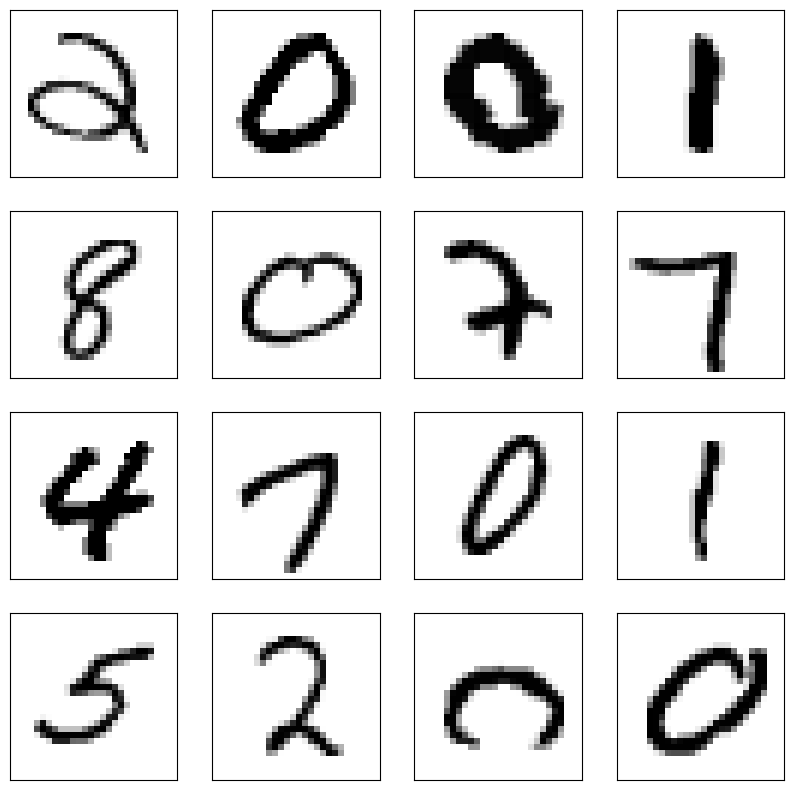

In [3]:
batch_size = 32

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_set = torchvision.datasets.MNIST(root=".", train=True, download=True, transform=transform)
subset_size = int(len(train_set) * 1)
# subset_size = 51_200
print(subset_size, subset_size // batch_size)
indices = np.random.choice(len(train_set), subset_size, replace=False)
train_subset = torch.utils.data.Subset(train_set, indices)
train_loader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True)

real_samples, mnist_labels = next(iter(train_loader))
plt.figure(figsize=(10, 10))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(real_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])

In [4]:
# class Discriminator(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.model = nn.Sequential(
#             nn.Linear(784, 2048),
#             nn.Dropout(0.2),
#             nn.ELU(),
#             nn.Linear(2048, 1024),
#             nn.Dropout(0.2),
#             nn.ELU(),
#             nn.Linear(1024, 512),
#             nn.Dropout(0.2),
#             nn.ELU(),
#             nn.Linear(512, 256),
#             nn.Dropout(0.2),
#             nn.ELU(),
#             nn.Linear(256, 1),
#             nn.Dropout(0.2),
#             nn.Sigmoid(),
#         )

#     def forward(self, x):
#         x = x.view(x.size(0), 784)
#         output = self.model(x)
#         return output


# class Generator(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.model = nn.Sequential(
#             nn.Linear(100, 256),
#             nn.Dropout(0.2),
#             nn.ELU(),
#             nn.Linear(256, 512),
#             nn.Dropout(0.2),
#             nn.ELU(),
#             nn.Linear(512, 1024),
#             nn.Dropout(0.2),
#             nn.ELU(),
#             nn.Linear(1024, 2048),
#             nn.Dropout(0.2),
#             nn.ELU(),
#             nn.Linear(2048, 784),
#             nn.Dropout(0.2),
#             nn.Tanh(),
#         )

#     def forward(self, x):
#         output = self.model(x)
#         output = output.view(x.size(0), 1, 28, 28)
#         return output


# discriminator = Discriminator().to(device)
# generator = Generator().to(device)

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            # nn.Dropout(0.1),
            nn.Linear(512, 256),
            nn.ReLU(),
            # nn.Dropout(0.1),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(x.size(0), 784)
        output = self.model(x)
        return output


class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 784),
            nn.Tanh(),
        )

    def forward(self, x):
        output = self.model(x)
        output = output.view(x.size(0), 1, 28, 28)
        return output


discriminator = Discriminator().to(device)
generator = Generator().to(device)

In [6]:
lr = 0.0001
num_epochs = 50
loss_function = nn.BCELoss()

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr, weight_decay=1e-4)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr, weight_decay=1e-4)

# optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-5)
# optimizer_generator = torch.optim.Adam(generator.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-5)
# optimizer_discriminator = torch.optim.SGD(discriminator.parameters(), lr=lr, weight_decay=l2, momentum=momentum)
# optimizer_generator = torch.optim.SGD(generator.parameters(), lr=lr, weight_decay=l2, momentum=momentum)

Elapsed time: 24.551424264907837 seconds
Avg D Loss: 0.07858030498027802 Avg D Loss: 4.649256706237793


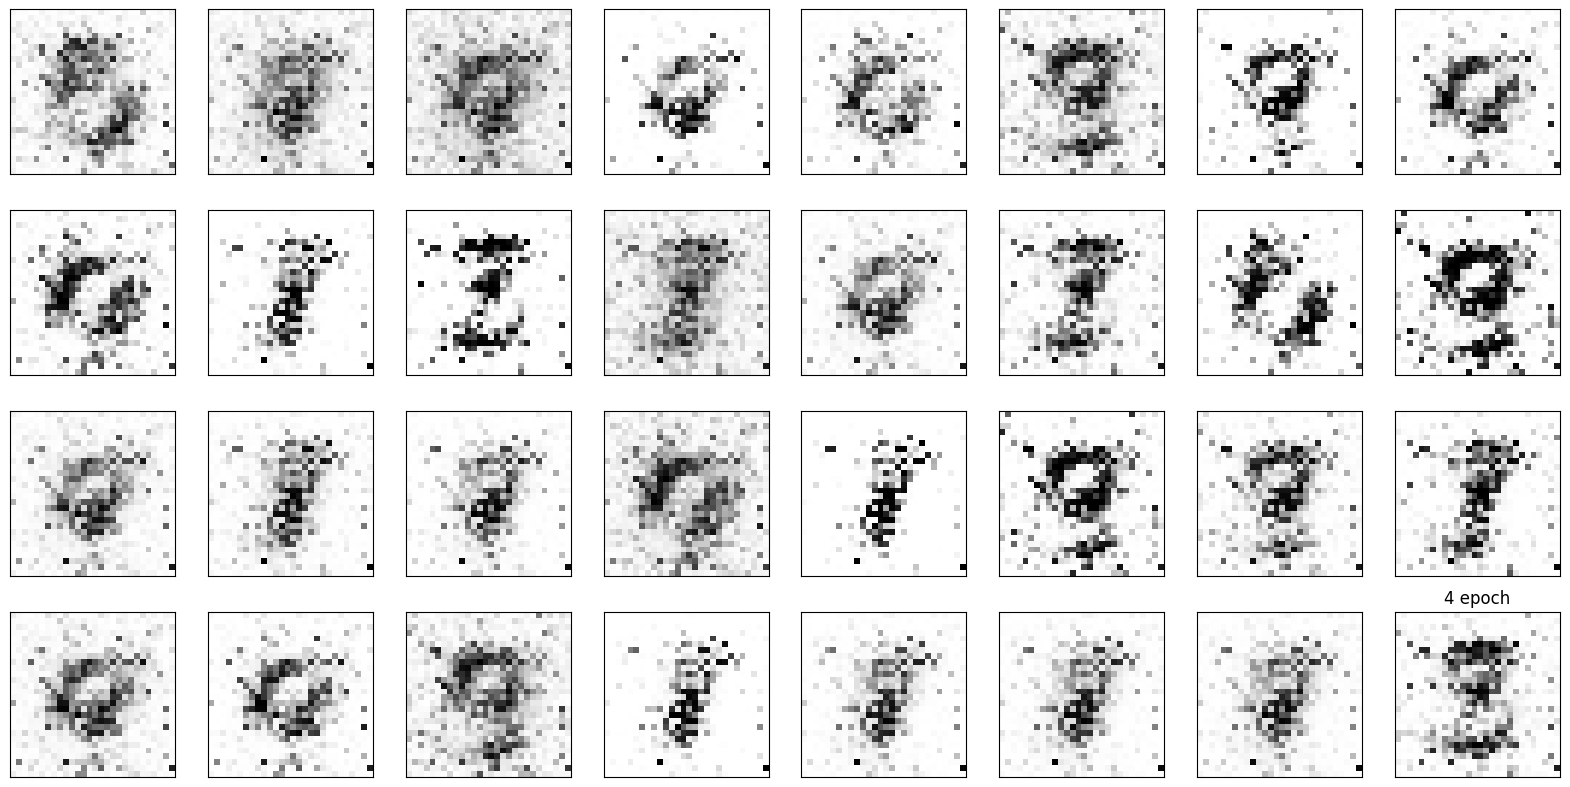

In [ ]:
output_dir = datetime.datetime.now().strftime("MNIST-GAN-EVO_%Y-%m-%d_%H-%M-%S")
os.makedirs(output_dir, exist_ok=True)

batches = subset_size // batch_size
evolution_samples = torch.randn((32, 100)).to(device=device)
for epoch in range(num_epochs):
    generator.train()
    start = time.time()
    sum_generator_loss = 0
    sum_discriminator_loss = 0
    for n, (real_samples, mnist_labels) in enumerate(train_loader):

        if n > 0 and n % 200 == 0:
            sys.stdout.write("\033[F")
            sys.stdout.write("\033[K")
            print(f"Epoch: {epoch} / {num_epochs}, {n} / {batches} batch Loss D.: {loss_discriminator:.4f} Loss G.: {loss_generator:.4f}")
        # Данные для тренировки дискриминатора
        real_samples = real_samples.to(device=device)
        real_samples_labels = torch.ones((batch_size, 1)).to( device=device)
        latent_space_samples = torch.randn((batch_size, 100)).to(device=device)
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1)).to(device=device)
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat((real_samples_labels, generated_samples_labels))

        # Обучение дискриминатора
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(output_discriminator, all_samples_labels)
        sum_discriminator_loss += loss_discriminator
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Данные для обучения генератора
        latent_space_samples = torch.randn((batch_size, 100)).to(device=device)

        # Обучение генератора
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(output_discriminator_generated, real_samples_labels)
        sum_generator_loss += loss_generator
        loss_generator.backward()
        optimizer_generator.step()

    if epoch % 1 == 0:
        generator.eval()
        avg_generator_loss = sum_generator_loss / batches
        avg_discriminator_loss = sum_discriminator_loss / batches
        clear_output(wait=True)
        print(f"Elapsed time: {time.time() - start} seconds")
        print(f"Avg D Loss: {avg_discriminator_loss} Avg D Loss: {avg_generator_loss}")
        generated_samples = generator(evolution_samples)
        generated_samples = generated_samples.cpu().detach()

        plt.figure(figsize=(20, 10))
        for i in range(32):
            ax = plt.subplot(4, 8, i + 1)
            plt.imshow(generated_samples[i].reshape(28, 28), cmap="gray_r")
            plt.xticks([])
            plt.yticks([])
        plt.title(f"{epoch} epoch")
        plt.savefig(f"{output_dir}/{epoch}.png")
        plt.show()